<a href="https://colab.research.google.com/github/santteegt/om-fol-timeseries/blob/master/LSTM_Model_Chest_device.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
!pip install torch-lr-finder

In [3]:
# !wget https://github.com/santteegt/om-fol-timeseries/archive/master.zip -O om-fol-timeseries.zip && unzip om-fol-timeseries.zip && rm om-fol-timeseries.zip
# !wget https://github.com/santteegt/om-fol-timeseries/raw/master/segmented_data/WESAD_segmented.zip && unzip -d data WESAD_segmented.zip && rm WESAD_segmented.zip
# from google.colab import files
# uploaded = files.upload()

!gdown --id 1_56HAZc2XSXQCAR4iZODq9VAoyq5CvAs  # segmented dataset on my Google drive

Downloading...
From: https://drive.google.com/uc?id=1_56HAZc2XSXQCAR4iZODq9VAoyq5CvAs
To: /content/all_subjects.csv
172MB [00:01, 154MB/s]


In [4]:
 !ls -l

total 167928
-rw-r--r-- 1 root root 171953449 Jul  6 12:35 all_subjects.csv
drwxr-xr-x 1 root root      4096 Jun 26 16:26 sample_data


## Load Subject Data

In [5]:
# BASE_PATH = './data'
# [subject for subject in os.listdir(BASE_PATH) if subject.endswith('.feather')]

In [6]:
df = pd.read_csv('all_subjects.csv', index_col=0)
df.shape

(121813, 79)

This should be done directly in the dataset:

In [7]:
df.label = df.label - 1

## Data Loader

In [8]:
class WESADDataset(Dataset):
    #Constructor is mandatory
    def __init__(self, dataframe, transform=None):
        # normalizer = StandardScaler()
        # Since different subjects have different responses on the signal values, min-max normalisation was conducted across different signals to normalize them to the same scale
        normalizer = MinMaxScaler()
        self.dataframe = dataframe.drop(columns=['subject','label'])
        # self.X = self.dataframe.astype(np.float32).to_numpy()
        # Normalize features
        self.X = normalizer.fit_transform(self.dataframe.astype(np.float32))
        self.labels = dataframe['label']
        self.transform = transform # e.g. torch.Tensor
    
    def to_torchtensor(self):            
        self.dataframe = torch.from_numpy(self.dataframe)
        self.labels = torch.from_numpy(self.labels)
    
    def __len__(self):
        #Mandatory
        '''Returns:
                Length [int]: Length of Dataset/batches
        '''
        return self.dataframe.shape[0]

    def __getitem__(self, idx): 
        #Mandatory 
        
        '''Returns:
                    Data [Torch Tensor]: 
                    Target [ Torch Tensor]:
        '''
        sample = self.X[idx]
        # sample = self.X[idx].reshape(1, -1)
        target = self.labels[idx]
                
        if self.transform:
            sample = self.transform(sample)

        return sample, target

In [9]:
def get_data_loader(subject, train_batch_size=128, val_batch_size=5):

    train = WESADDataset(df[df['subject'] != subject].reset_index(drop=True))
    test = WESADDataset(df[df['subject'] == subject].reset_index(drop=True))

    train_dl = torch.utils.data.DataLoader(train, batch_size=train_batch_size, shuffle=True, pin_memory=True, num_workers=4)
    val_dl = torch.utils.data.DataLoader(test, batch_size=val_batch_size, shuffle=False, pin_memory=True, num_workers=4)
    
    return train_dl, val_dl

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Methods & utils for model training

In [11]:
from sklearn.metrics import f1_score

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def f1(output, label, threshold=0.5, beta=1):
    probs = torch.argmax(output.data.to('cpu'), dim=1)
    preds = label.data.to('cpu')
    return f1_score(preds, probs, average='macro')

def plot_scores(history):
    t_acc = [x['train_acc'] for x in history]
    plt.plot(t_acc, '-x', label='Train Acc')

    accuracies = [x['val_acc'] for x in history]
    f1 = [x['val_f1'] for x in history]
    plt.plot(accuracies, '-x', label='Valid Acc')
    plt.plot(f1, '-x', label='Val F1')
    plt.xlabel('epoch')
    plt.ylabel('Score')
    plt.title('Score vs. No. of epochs')
    plt.legend();

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [12]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        data, labels = batch 
        out = self(data)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        data, labels = batch 
        out = self(data)                    # Generate predictions
        # print('out', out.shape)
        loss = F.cross_entropy(out, labels)   # Calculate loss
        # print('loss', loss.shape)
        out = F.softmax(out, dim=1)           # Apply Softmax
        acc = accuracy(out, labels)           # Calculate accuracy
        f1_ = f1(out, labels)                  # Calculate F1
        return {'val_loss': loss.detach(), 'val_acc': acc, 'val_f1': f1_}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        batch_f1 = [x['val_f1'] for x in outputs]
        # print('batch_f1', len(batch_f1))
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        epoch_f1 = np.mean(np.array(batch_f1))         # Combine F1 scores
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_f1': epoch_f1.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_f1: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'], result['val_f1']))

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, optimizer):
    history = []
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_accs = []
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            data, labels = batch
            train_out = F.softmax(model(data), dim=1)
            train_accs.append(accuracy(train_out, labels))


        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        history.append(result)

        # if epoch < 5 or (epoch + 1) % 5 == 0:
        model.epoch_end(epoch, result)
            
    return history

## Models

In [14]:
class WesadFeedForward(BaseModel):
    def __init__(self, input_dim, output_dim=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Linear(128, output_dim),
            #nn.Dropout(0.5),
            # nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.network(x)


class WesadLSTM(BaseModel):
    def __init__(self, input_dim, hidden_dim, output_dim=3, lstm_layers=1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.classes = output_dim
        # self.linear1 = nn.Linear(input_dim, input_dim)
        # self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=0.2)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=input_dim, num_layers=lstm_layers, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        xb = x.view(-1, 1, self.input_dim)
        # print('x', xb.shape)
        # out = self.linear1(x)
        # out = x.view(x.shape, -1)
        # print(out.shape)
        # out = self.dropout(out)
        # lstm_out, (ht, ct) = self.lstm(out)
        # out = self.fc(ht[-1])
        lstm_out, _ = self.lstm(xb)
        # print(lstm_out.view(-1, self.hidden_dim).shape)
        out = self.fc(lstm_out.view(-1, self.hidden_dim))
        # out = self.dropout(out)
        # out = self.softmax(out)
        # out = F.softmax(out, dim=1)
        return out.view(-1, self.classes)


## General Model Parameters

In [15]:
subjects = df['subject'].unique()
subjects.sort()
device = get_default_device()

train_batch_size = 25
val_batch_size = 5
input_dim = df.drop(columns=['subject', 'label']).shape[1]
output_dim = 3
lstm_layers = 5

In [16]:
# lrs = [0.5, 0.1, 0.01, 0.001]
# epochs = [20, 20, 20,  20]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


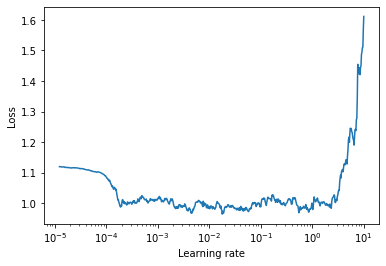

In [17]:
from torch_lr_finder import LRFinder

max_lr = 1e-5
# grad_clip = 0.001
# weight_decay = 1e-4
opt_func = torch.optim.Adam
criterion = F.cross_entropy
train_dl, val_dl = get_data_loader(subject='S2', train_batch_size=train_batch_size, val_batch_size=val_batch_size)

# model = WesadFeedForward(input_dim, output_dim)
model = WesadLSTM(input_dim=input_dim, hidden_dim=input_dim, output_dim=output_dim, lstm_layers=lstm_layers)
# optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
optimizer = opt_func(model.parameters(), lr=max_lr)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=10000, num_iter=1000)
lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

## Running models - LOSO CV

In [18]:
epochs = 20
lr = 1e-4

models = []
histories = []
val_histories = []
for subject in subjects:
    history = []
    print('LOSO', subject)
    train_dl, val_dl = get_data_loader(subject, train_batch_size=train_batch_size, val_batch_size=val_batch_size)
    train_ddl = DeviceDataLoader(train_dl, device)
    val_ddl = DeviceDataLoader(val_dl, device)
    # model = to_device(WesadFeedForward(input_dim, output_dim), device)
    model = to_device(WesadLSTM(input_dim=input_dim, hidden_dim=input_dim, 
                                output_dim=output_dim, lstm_layers=lstm_layers), device)

    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # history += fit(epochs, lr, model, train_ddl, val_ddl, optimizer)
    break

LOSO S10


In [19]:
def try_batch(dl):
    model.eval()
    for data, labels in dl:
        # print(data)
        # print(labels)
        print('data.shape:', data.shape)
        out = model(data)
        print('out[0]', out[0])
        print('softmax(out[0]):', F.softmax(out, dim=1)[0])
        _, p = torch.max(F.softmax(out, dim=1), dim=1)
        print(p[0])
        break

try_batch(train_ddl)

data.shape: torch.Size([25, 77])
out[0] tensor([-0.1038,  0.0907, -0.0787], device='cuda:0', grad_fn=<SelectBackward>)
softmax(out[0]): tensor([0.3086, 0.3749, 0.3165], device='cuda:0', grad_fn=<SelectBackward>)
tensor(1, device='cuda:0')


In [20]:
history = [evaluate(model, val_ddl)]
history

[{'val_acc': 0.31704410910606384,
  'val_f1': 0.3168419036267665,
  'val_loss': 1.1131939888000488}]

In [21]:
epochs = 5
lr = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
history += fit(epochs, lr, model, train_ddl, val_ddl, optimizer)


Epoch [0], train_loss: 0.4630, train_acc: 0.8153, val_loss: 0.3250, val_acc: 0.8965, val_f1: 0.8817



Epoch [1], train_loss: 0.1342, train_acc: 0.9572, val_loss: 0.5303, val_acc: 0.8629, val_f1: 0.8468



Epoch [2], train_loss: 0.0932, train_acc: 0.9718, val_loss: 0.6836, val_acc: 0.8338, val_f1: 0.8255



Epoch [3], train_loss: 0.0777, train_acc: 0.9771, val_loss: 0.4298, val_acc: 0.8890, val_f1: 0.8769



Epoch [4], train_loss: 0.0615, train_acc: 0.9816, val_loss: 0.4548, val_acc: 0.8970, val_f1: 0.8842


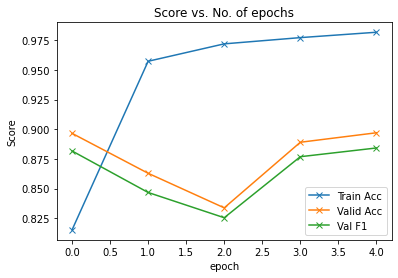

In [23]:
plot_scores(history[1:])

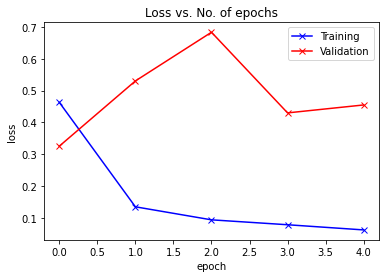

In [24]:
plot_losses(history[1:])

TODOs

* Use [scorch](https://github.com/skorch-dev/skorch) for hyperparameter tuning
* Apply SMOTE oversampling technique to tackle class imbalance and naturally adapt it as a data augmentation
* a model combining a CNN to automatically extracts local features and RNN to extract temporal dependencies
* apply a scalogram to the entire signal in order to get an equivalent image dataset
    * *The scalogram is basically a visible time-frequency illustration of a signal using wavelet transform.*
* Experiment with fusion schemes to apply different signals for Affect Recognition

Related papers:

* Psychological Stress Detection Using Deep Convolutional Neural Networks
* An Explainable Deep Fusion Network for Affect Recognition Using Physiological Signals.pdf